In [52]:
using Pkg
# Pkg.activate("") #path/to/project.toml/file goes here 

packages_to_install = ["MLDatasets", "Plots", "Statistics", "Distributions", "Random", "Flux", "Yao", "FLOYao"]

additional = ["PythonCall", "BenchmarkTools"]

#MLDatasets - provides MNIST
#Plots - plotting graphs of loss
#Statistics - setting up pprior(), the prior distribution that the Generator samples from
#Distributions - same^
#Random - same^
#Flux - ML library to train Discriminator
#Yao - QC library
#FLOYao - QC library for simulating matchgates
#PythonCall - (not needed) plotting plotting and display of images 
#BenchmarkTools - (not needed) Benchmarking certain functions 

for pkg in packages_to_install
    Pkg.add(pkg)
end

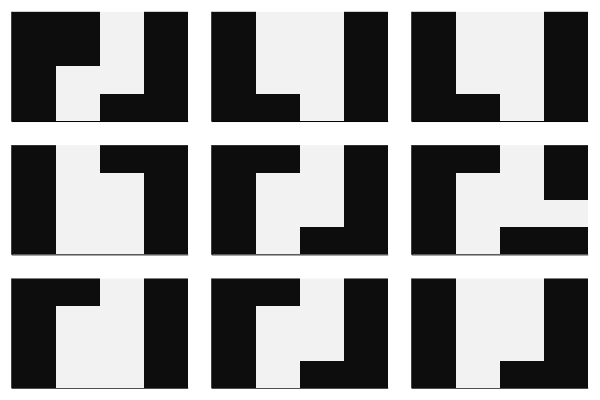

In [53]:
using MLDatasets
using Plots
using Statistics
using Distributions
using Random

train = 9 # Size of training dataset

digit = 1 # Digit to be learned
image_size = 28 # Size of image
compress_size = 4 # Size of compressed image

function compress(img, original = image_size, compress = compress_size) # Given a square image "img" with size "original", compresses it to size "compress", via mean pooling 
    ratio = original ÷ compress
    compressed = zeros(compress, compress)
    a = []
    for i in 0:compress-1
        for j in 0:compress-1
            empty!(a)
            for p in 1:ratio
                for q in 1:ratio
                    push!(a, img[(ratio*i) + p, (ratio*j) + q])
                end
            end
            compressed[i+1, j+1] = max ? maximum(a)
        end
    end
    return compressed
end

train_set = MNIST(:train)
train_labels = MNIST(split=:train).targets

data_train = [] # Training dataset
c = 1
trainstats = [] # List of total number of 1s in each training image, used for setting up pprior() later
for _ in 1:train
    while train_labels[c] != digit
        c += 1
    end
    push!(data_train, compress(rotl90(train_set[c][1])) .> 0.5) #Representing each image as a bit matrix
    push!(trainstats, sum(compress(train_set[c][1]) .> 0.5))
    c += 1
end

plot([heatmap(x, color=:grays, colorbar = false, ticks = false) for x in data_train]...)


In [54]:
using Yao
using FLOYao
using Flux

N = compress_size^2 #Number of qubits

d = Chain(Dense(N, 10, relu), Dense(10, 1, sigmoid)) #Discriminator is a Neural Network
nparams = sum(length, Flux.params(d))
println("Number of parameters in discriminator: $nparams")

In [ ]:
layers = 5
g = chain(N) #Generator is a Matchgate ansatz
for _ in 1:layers
    for i in 1:N-1
        push!(g, rot(kron(N, i => X, i+1 => X), 0.))
    end
    for i in 1:N
        push!(g, put(N, i => Rz(0.)))
    end
end

nparams = nparameters(g)
println("Number of parameters in generator: $nparams")  
dispatch!(g, :random);

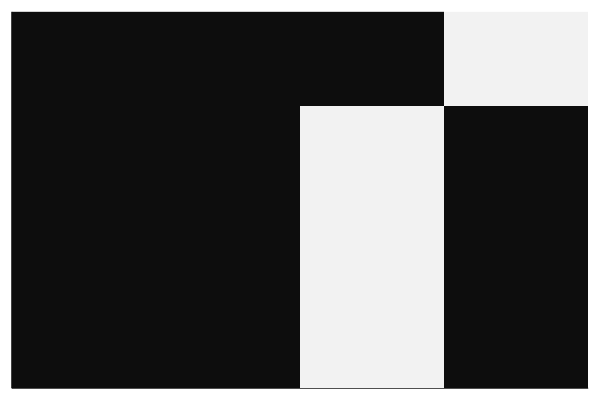

In [55]:
using FLOYao
using Random
using Distributions

mu = mean(trainstats)
sigma = std(trainstats)
println("μ: $mu")
println("σ: $sigma")
dist = Normal(mu, sigma)
ratio = rand(dist) / N

function pprior(r = ratio) #For each square, probability "ratio" that it's white, where ratio ~ (1/N) * N(mean(data), std(data)); maybe we can vary pprior later?
    a = rand(N) .< r
    return FLOYao.product_state(Int.(a)) #Returns a MajoranaReg so that it can be sent through the Generator 
end

pprior_example = rand(N) .< ratio #Sampling from pprior()
heatmap(rotl90(reshape(pprior_example, compress_size, compress_size)) .> 0.5, color=:grays, colorbar = false, ticks = false)

In [56]:
using Flux: train!

batch_size = train #Batch size (If less than train, then picks batch_size random images from dataset TODO)

#g takes as input MajoranaReg 
#d takes as input measure(x |> g)

function convertgd(g_output::Vector) #turns the output of reg |> g |> measure into an Int vector so that it can be sent through d
    result = []
    for i in 1:N 
        push!(result, g_output[1][end - i + 1])
    end
    Int.(result)
end

function run_circuit(z::MajoranaReg) #applies D(G(z)) where z is a MajoranaReg sampled from pprior()
    g_output = z |> g |> measure
    d_input = convertgd(g_output)
    d_output = d_input |> d
    d_output |> first
end

function run_d(x::BitMatrix) #this function applies D(x), where x is an element of data_train 
    d_output = x |> vec |> d
    d_output |> first
end

t = time() #timing how long it takes to run the circuit once (not very long)
result = run_circuit(pprior())
println("Discriminator output: $result")
println("time elapsed for run_circuit and measuring: ", time() - t)

In [ ]:
function gLoss(z::MajoranaReg) #z is sampled from pprior()
    -log(run_circuit(z))
end

function dLoss(m, real, fake) #m is the discriminator, real is the actual data, fake is G(z) where z is sampled from pprior(); Flux.train! requires the actual neural network to be a parameter in the loss function
    -(log.(m(real)) + log.(1 .- m(fake))) |> first
end

ε = 0.001 
function finitediff_grad(z::MajoranaReg, eps = ε) #Returns the approximate gradient of G, using forward finite differences
    original = gLoss(z)
    temp_params = parameters(g)
    grad = zeros(nparameters(g))
    temp = 0
    for i in 1:nparameters(g)
        temp = parameters(g)[i]
        temp_params[i] = temp + eps
        dispatch!(g, temp_params)
        plus = gLoss(z)
        grad[i] = (plus - original) / eps
        temp_params[i] = temp
        dispatch!(g, temp_params)
    end
    grad
end

z = pprior()
@benchmark finitediff_grad(z);

In [57]:
g_lr = 0.001 #Learning rate for Generator
d_lr = 0.1

#Different possible optimizers for the Discriminator; currently using ADAM
opt_flag = 1
if opt_flag == 1
    d_opt = Flux.setup(Adam(), d) 
elseif opt_flag == 2
    d_opt = Flux.setup(Descent(d_lr), d)
elseif opt_flag == 3
    d_opt = Flux.setup(SGD(), d)
end

gLoss_values = [] #Loss values of G (for plotting)
dLoss_values = [] #Loss values of D (for plotting)
g_epochs = 50 #Number of training epochs for G, within each overall epoch
d_epochs = 10 #Number of training epochs for D, within each overall epoch
epochs = 10 

#Collecting fake samples for the Generator to learn
fake_samples = []
for m in 1:batch_size
    z = pprior()
    push!(fake_samples, z)
end

In [ ]:
for i in 1:epochs
    t = time()
    for j in 1:g_epochs
        s = 0
        grads = []
        for m in 1:batch_size
            z = fake_samples[m]
            push!(grads, finitediff_grad(z, ε))
            s += gLoss(z)
        end
        println(mean(grads))
        dispatch!(-, g, mean(grads) * g_lr)
        push!(gLoss_values, s / batch_size)
    end
    for j in 1:d_epochs
        real = []
        fake = []
        for m in 1:batch_size
            x = data_train[m] |> vec 
            push!(real, Int.(x))
            z = pprior()
            push!(fake, convertgd(z |> g |> measure))
        end
        data = collect(zip(real, fake)) 
        Flux.train!(dLoss, d, data, d_opt)
        s = 0
        for x in data
            s += dLoss(d, x[1], x[2])        
        end
        push!(dLoss_values, s / batch_size)
    end
    println("iteration $i done in: ", time() - t)
end

#500 extra training epochs for the Generator because it's bad
for j in 1:500
    s = 0
    grads = []
    for m in 1:batch_size
        z = fake_samples[m]
        push!(grads, finitediff_grad(z, ε))
        s += gLoss(z)
    end
    dispatch!(-, g, mean(grads) * g_lr)
    push!(gLoss_values, s / batch_size)
end

In [ ]:
plot(gLoss_values, title = "Generator Loss", linewidth=3) #Plot of Generator loss

In [ ]:
plot(dLoss_values, title = "Discriminator Loss", linewidth=3) #Plot of Discriminator loss

In [ ]:
#Testing the Discriminator

d_fake = run_circuit(pprior())
println("fake data: $d_fake") #Should print a number close to 0

index = rand(1:train)
d_real = run_d(data_train[index])
println("real data: $d_real") #Should print a number close to 1

In [ ]:
#Testing the Generator

nsamples = 4
samples = []
for i in 1:nsamples
    reg = fake_samples[i]
    s = reg |> g |> measure
    push!(samples, convertgd(s))
end
plot([heatmap(rotl90(reshape(s, compress_size, compress_size)), color=:grays, colorbar = false, ticks = false) for s in samples]...) #Should output an image that looks like the data